# Flight Delay Classifier v2
With the middling success of v1 (~68% accuracy for predicting delayed vs on-time), there is an opportunity to introduce more data in an effort to increase the accuracy of the model. Specifically, we will seek to incorporate weather data from the originating airport to the model. The logic is straightfowrard: our previous data was missing key information about the pre-flight conditions and adding them to the model will provide valuable data for a large chunk of delays (75% of delays > 15 minutes are due to weather https://www.afar.com/magazine/weather-conditions-affecting-flights-delays). 

The weather data was scraped from Weather Underground, namely the min, max, and average temperature, wind speed, and pressure along with total precipitation for each day that we have flight delay data. Our initial attempts will use these raw values, but we can also transform them as needed to include information such as "snowing" or "windy".

In [139]:
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict, cross_validate, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score
from scipy.stats import randint, uniform
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

## Merging Weather and Delay Data
Our first step is to load the weather and delay data, and then merge them into a single data frame. The goal is to have each row contain the full information of a flight including the weather. This should be doable with a simple merge between the delays and weather where we do a left merge on delays.

In [99]:
# Load all the PDX files
def load_flight_info(data_dir, pat_str):
    """
    Loads a single data frame containing all the data in data_dir with files matching the pat_str
    """
    df = pd.DataFrame()
    for entry in os.listdir(data_dir):
        # Construct full path
        full_path = os.path.join(data_dir, entry)

        # Check if it is actually a file and if it matches the pattern
        if os.path.isfile(full_path) and fnmatch.fnmatch(entry, pat_str):
            df = pd.concat([df, pd.read_csv(full_path, skiprows=7)])
            print(f'Loaded {full_path} added to dataframe.')

    return df

def load_weather_info(data_dir, pat_str):
    """
    Loads a single data frame containing all the data in data_dir with files matching the pat_str
    """
    df = pd.DataFrame()
    for entry in os.listdir(data_dir):
        # Construct full path
        full_path = os.path.join(data_dir, entry)

        # Check if it is actually a file and if it matches the pattern
        if os.path.isfile(full_path) and fnmatch.fnmatch(entry, pat_str):
            df = pd.concat([df, pd.read_csv(full_path)])
            print(f'Loaded {full_path} added to dataframe.')

    return df

In [100]:
delay_df = load_flight_info('C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays', 'PDX*')
weather_df = load_weather_info('C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/weather', 'PDX*')

Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_AA_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_AS_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_B6_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_DL_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_F9_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_G4_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_HA_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_MQ_2_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data S

In [101]:
# Get rid of the day of the month column (unnamed)
weather_df.drop(['Unnamed: 0'], axis=1, inplace=True)
weather_df.head()

,Temp_Max,Temp_Avg,Temp_Min,WindSpeed_Max,WindSpeed_Avg,WindSpeed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,PrecipitationTotal,Date
0,51,48.4,46,20,12.8,7,30.1,29.9,29.8,0.05,2021-01-01
1,52,50.5,48,24,14.7,8,30.0,29.9,29.7,0.20,2021-01-02
2,53,48.7,43,21,12.0,0,30.1,29.9,29.7,0.96,2021-01-03
3,53,48.4,46,21,13.1,3,30.1,29.7,29.6,0.16,2021-01-04
4,50,47.0,43,18,11.8,5,30.1,30.1,29.9,0.54,2021-01-05


In [102]:
delay_df.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,G4,01/02/2024,742.0,290NV,AZA,10:08,10:12,160.0,152.0,4.0,10:24,12.0,0.0,0.0,0.0,0.0,0.0
1,G4,01/02/2024,1588.0,253NV,PVU,16:23,16:14,109.0,113.0,-9.0,16:30,16.0,0.0,0.0,0.0,0.0,0.0
2,G4,01/02/2024,3234.0,253NV,IDA,11:10,11:05,93.0,89.0,-5.0,11:17,12.0,0.0,0.0,0.0,0.0,0.0
3,G4,01/03/2022,9.0,247NV,IDA,11:13,12:16,92.0,83.0,63.0,12:28,12.0,39.0,0.0,0.0,0.0,15.0
4,G4,01/03/2023,76.0,218NV,IDA,19:17,21:05,91.0,96.0,108.0,21:17,12.0,0.0,0.0,5.0,0.0,108.0


In [103]:
delay_df['Date'] = pd.to_datetime(delay_df['Date (MM/DD/YYYY)'])
delay_df.drop(['Date (MM/DD/YYYY)'], axis=1, inplace=True)
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

In [104]:
combined_df = pd.merge(delay_df, weather_df, how='left', left_on='Date', right_on='Date')

## Considerations for Weather Features
This new dataset has introduced a number of possible features that we should examine before including them (or not) in our model. The items of interest are:
* Min, max, and average temperature
* Min, max, and average wind speed
* Min, max, and average pressure
* Total precipitation.

Going on our intuition, we can at least drop three of these items. Average temperature does not tell us anything significant that we do not already glean from the minimum and maximum temperatures. Similarly, the minimum wind speed will not have any impact on our model as the floor is 0 and we can safely say that no flight has been delayed due to calm conditions. Lastly, we can drop the average pressure using similar reasoning as for the average temperature. We really would only care about pressure changes (or extreme minimum pressures). 

Our remaining items all appear simple to work with--unimodal and with roughly normal distributions in most cases. The exceptions being WindSpeed_Avg, WindSpeed_Max, and PrecipitationTotal, which have relatively skewed distributions. We will make sure to normalize those as best we can in the data preparation steps.

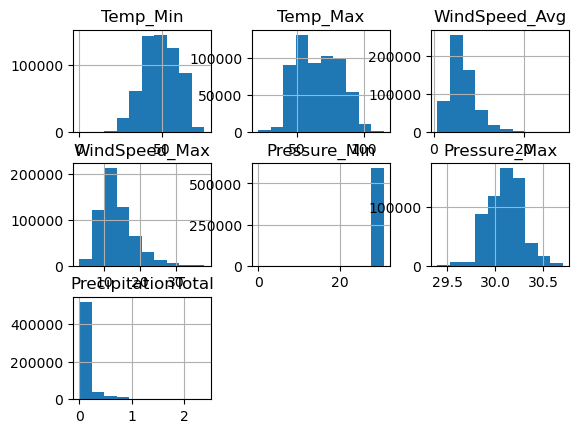

In [105]:
combined_df.drop(['Temp_Avg', 'WindSpeed_Min', 'Pressure_Avg'], axis=1, inplace=True)
combined_df.hist(['Temp_Min', 'Temp_Max', 'WindSpeed_Avg', 'WindSpeed_Max', 'Pressure_Min', 'Pressure_Max', 'PrecipitationTotal']);

## Data Preparation
We will proceed in a very similar line of data preparation as we did in v1, however, we will take advantage of some of our learnings. In this case, we will not be making use of the destination airport column. This adds a ton of features that did not exhibit much predictive power per our random forest classifier so we should avoid wasting processing power on it.

As such, the data prepation steps we will undertake prior to classification are as follows:
* Drop na values in 'Departure delay (Minutes)'.
* Create a new column marking the flight as delayed (1) or on-time (0).
* Convert the date and time to a day of the year and departure hour.
* Drop unused columns.
* Create a one hot encoder for the carrier code.
* Write sine/cosine transformations of the day of year and departure hour.
* Use min/max and robust scaling on the weather data.
* Set up a pipeline to combine all the transformations.

In [106]:
combined_df.dropna(subset='Departure delay (Minutes)', inplace=True)

combined_df['Delayed'] = np.where(combined_df['Departure delay (Minutes)'] > 0, 1, 0)

combined_df['DayOfYear'] = combined_df['Date'].dt.dayofyear
combined_df['DepartureTimeHour'] = pd.to_datetime(combined_df['Scheduled departure time'], format='%H:%M').dt.hour + pd.to_datetime(combined_df['Scheduled departure time'], format='%H:%M').dt.minute / 60

In [107]:
combined_df.columns.values

array(['Carrier Code', 'Flight Number', 'Tail Number',
       'Destination Airport', 'Scheduled departure time',
       'Actual departure time', 'Scheduled elapsed time (Minutes)',
       'Actual elapsed time (Minutes)', 'Departure delay (Minutes)',
       'Wheels-off time', 'Taxi-Out time (Minutes)',
       'Delay Carrier (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)',
       'Delay Late Aircraft Arrival (Minutes)', 'Date', 'Temp_Max',
       'Temp_Min', 'WindSpeed_Max', 'WindSpeed_Avg', 'Pressure_Max',
       'Pressure_Min', 'PrecipitationTotal', 'Delayed', 'DayOfYear',
       'DepartureTimeHour'], dtype=object)

In [108]:
cols_to_drop = ['Flight Number', 'Tail Number', 'Destination Airport', 'Scheduled departure time',
       'Actual departure time', 'Scheduled elapsed time (Minutes)',
       'Actual elapsed time (Minutes)', 'Departure delay (Minutes)',
       'Wheels-off time', 'Taxi-Out time (Minutes)',
       'Delay Carrier (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)',
       'Delay Late Aircraft Arrival (Minutes)']
combined_df.drop(cols_to_drop, axis=1, inplace=True)

In [109]:
# one hot encoder for Carrier Code values
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

cat_pipeline = Pipeline([
    ('encoder', one_hot_encoder)
])

# sine and cosine transformer classes to be used for date and time variables
class SinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.sin(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_sin' for col in input_features]

class CosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.cos(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_cos' for col in input_features]

In [131]:
# Now set up which attributes get which transforms using a ColumnTransformer
time_attribs = ['DepartureTimeHour']
date_attribs = ['DayOfYear']
weather_attribs = ['Temp_Max','Temp_Min', 'WindSpeed_Max', 'WindSpeed_Avg', 'Pressure_Max', 'Pressure_Min', 'PrecipitationTotal']
cat_attribs = ['Carrier Code']

weather_pipeline = Pipeline([
    ('robust_scaler', RobustScaler()),
    ('minmax_scaler', MinMaxScaler())
])
feature_transformer = ColumnTransformer(
    transformers=[
        ('categorical', one_hot_encoder, cat_attribs),
        ('day_sin', SinTransformer(period=365), date_attribs),
        ('day_cos', CosTransformer(period=365), date_attribs),
        ('hour_sin', SinTransformer(period=24), time_attribs),
        ('hour_cos', CosTransformer(period=24), time_attribs),
        ('weather_scale', weather_pipeline, weather_attribs)
])

## Training a Random Forest
Now, we will move on to fitting a random forest classifier to our data. We will run a randomized search using cross-validation to tune the hyperparameters and, from there, we'll see how our model does!

In [132]:
df_features = combined_df.drop(['Delayed'], axis=1)
df_labels = combined_df['Delayed']
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.2)

In [133]:
rnd_forest_pipeline = Pipeline([
    ('data_transformer', feature_transformer),
    ('rnd_forest', RandomForestClassifier())
])

# We will be tuning our decision tree
param_distribs = {'rnd_forest__criterion': ['gini', 'entropy', 'log_loss'],
                  'rnd_forest__min_samples_split': randint(low=10, high=30),
                  'rnd_forest__min_samples_leaf': randint(low=10, high=30),
                  'rnd_forest__max_leaf_nodes': randint(low=100, high=300),
                  'rnd_forest__max_depth': randint(low=10, high=30),
                  'rnd_forest__max_features': randint(low=100, high=300)}
rnd_forest_search = RandomizedSearchCV(rnd_forest_pipeline, param_distributions=param_distribs, 
                                n_iter=10, cv=3, scoring='accuracy')
rnd_forest_search.fit(X_train, y_train.values.ravel())

,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'rnd_forest__criterion': ['gini', 'entropy', ...], 'rnd_forest__max_depth': <scipy.stats....002922679E970>, 'rnd_forest__max_features': <scipy.stats....002922679E9E0>, 'rnd_forest__max_leaf_nodes': <scipy.stats....002922679ECF0>, ...}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [136]:
best_forest_model = rnd_forest_search.best_estimator_

In [137]:
# Use the name given in the 'steps' list ('preprocessor' in this case)
feature_names = best_forest_model.named_steps['data_transformer'].get_feature_names_out()

# 6. Get the feature importances from the regressor step
# Use the name given in the 'steps' list ('regressor' in this case)
importances = best_forest_model.named_steps['rnd_forest'].feature_importances_

# 7. Create a pandas Series for easy viewing and sorting
feature_importances_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importances_series[:15])

categorical__Carrier Code_WN         0.386501
hour_sin__DepartureTimeHour_sin      0.301847
day_cos__DayOfYear_cos               0.092645
hour_cos__DepartureTimeHour_cos      0.042438
day_sin__DayOfYear_sin               0.036950
weather_scale__Temp_Max              0.026175
weather_scale__Temp_Min              0.023166
weather_scale__WindSpeed_Avg         0.021922
weather_scale__PrecipitationTotal    0.013450
weather_scale__WindSpeed_Max         0.010211
categorical__Carrier Code_HA         0.008593
weather_scale__Pressure_Min          0.008478
categorical__Carrier Code_OO         0.007995
weather_scale__Pressure_Max          0.007177
categorical__Carrier Code_B6         0.002955
dtype: float64


In [138]:
y_pred = best_forest_model.predict(X_test)

In [140]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy score: {accuracy}')

Model accuracy score: 0.6954875195664248


In [159]:
pred_df = X_test.copy()
pred_df['Delayed'] = y_pred

In [160]:
pred_df.head()

,Carrier Code,Date,Temp_Max,Temp_Min,WindSpeed_Max,WindSpeed_Avg,Pressure_Max,Pressure_Min,PrecipitationTotal,DayOfYear,DepartureTimeHour,Delayed
367891,AS,2025-01-05,54.0,48.0,16.0,4.6,30.3,30.1,0.64,5,10.950000,0
364506,QX,2024-12-09,51.0,36.0,7.0,1.9,30.5,30.4,0.06,344,15.483333,0
182323,WN,2021-07-24,90.0,63.0,20.0,8.3,30.1,30.0,0.00,205,7.000000,0
198230,WN,2021-08-10,92.0,67.0,16.0,8.1,30.1,29.9,0.00,222,18.916667,1
451882,DL,2025-01-31,54.0,41.0,16.0,10.1,29.9,29.7,0.30,31,19.183333,0


In [167]:
pred_df.groupby('Carrier Code')['Delayed'].value_counts(normalize=True)

Carrier Code  Delayed
AA            0          0.958420
              1          0.041580
AS            0          0.989848
              1          0.010152
B6            0          0.592233
              1          0.407767
DL            0          0.990723
              1          0.009277
F9            0          0.990741
              1          0.009259
G4            0          0.993769
              1          0.006231
HA            0          0.745640
              1          0.254360
MQ            0          1.000000
NK            0          0.995183
              1          0.004817
OO            0          0.988912
              1          0.011088
QX            0          0.991975
              1          0.008025
WN            1          0.585693
              0          0.414307
YV            0          1.000000
Name: proportion, dtype: float64

# Summary
Ultimately, it seems as though adding our weather data into the mix did not signifcantly improve the accuracy of our model. We still come in at 69.5%accuracy (a roughly .5% improvement over neural networks not given weather data). Interestingly, the weather data does come in just behind the date and time in terms of importance to the random forest, but far and away the strongest predictor is whether or not a flight is a Southwest Airlines flight. That feature ransk ahead of all others for importance in the random forest classification. This is not completely unexpected given the fact that Southwest Airlines is late significantly more often than other airlines. If the model simply guesses a Southwest Flight will be late, it will already hit a nearly 50% accuracy. How could weather data hope to compete with such a strong predictor??

For next time, we will investigate if this trend holds at other airports. Will Southwest still be a strong predictor of delays? Or do airlines fair differently depending on their originating airport? Does weather have stronger predictive power at some airports than other? PDX has admittedly mild weather year round, but others like Denver can have powerful storms move in quickly around the mountains so maybe we will see stronger effects there.